In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import re
import collections
from matplotlib.colors import LinearSegmentedColormap

import sys
import palantir
import os
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import font_manager
import csv

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
#Set file directory to import from and date
filedir = '/Users/4472241/scCode/palantirEmbeddings/mapToRep1/'
date = '12-21-2020'
# Inline plotting
%matplotlib inline

In [3]:
#define function to read in branchProbs and format to percent greater than X (.5)
def csv_import_fn(i, colNames):
    if (i<40):
        sampleID = 'cmml'+str(i)
    else:
        sampleID = 'normal'+str(i-39)
    
    #Import dataframe from r specifying diff potential and branch Prob
    branchProb_diffPot_df = pd.read_csv(filedir+sampleID+'branchProbs_diffPot.csv', index_col=0)

    branchProb_diffPot_df = branchProb_diffPot_df[cols]
    
    #Count how many cells we have
    denominator = branchProb_diffPot_df.count()[1]

    #Count the cells with >50% branch probability for each branch
    gt75 = branchProb_diffPot_df.gt(.5)
    outputArray = gt75.sum()

    #Convert to numpy array and add the unassigned cells to 5th column (HSC Precursors)
    percent = outputArray/denominator
    percentages = np.zeros(8)
    percentages = percent.values

    percentages = np.append(percentages, 1-sum(percentages[1:6]))
    return percentages

In [5]:
#Set ordering to group HMA (5-39), Chemo (36), Rux (34,38), 
##CMML, normal (normals are last 40+)
ordering = [5,6,7,17,32,33,35,37,39,36,34,38,1,2,3,4,8,9,10,
            11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,
            29,30,31, 40, 41, 42, 43,44,45,46]
percentagesNumPy_HSC = np.zeros((len(ordering),8))
cols = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in ordering:
    percentagesNumPy_HSC[count,:] = csv_import_fn(i, cols)
    count = count+1

In [6]:
#Subtract average of normals to plot the relative percentages
normalsOnly = percentagesNumPy_HSC[39:,:]
averages = np.mean(normalsOnly,0)

plotRelative = percentagesNumPy_HSC-averages

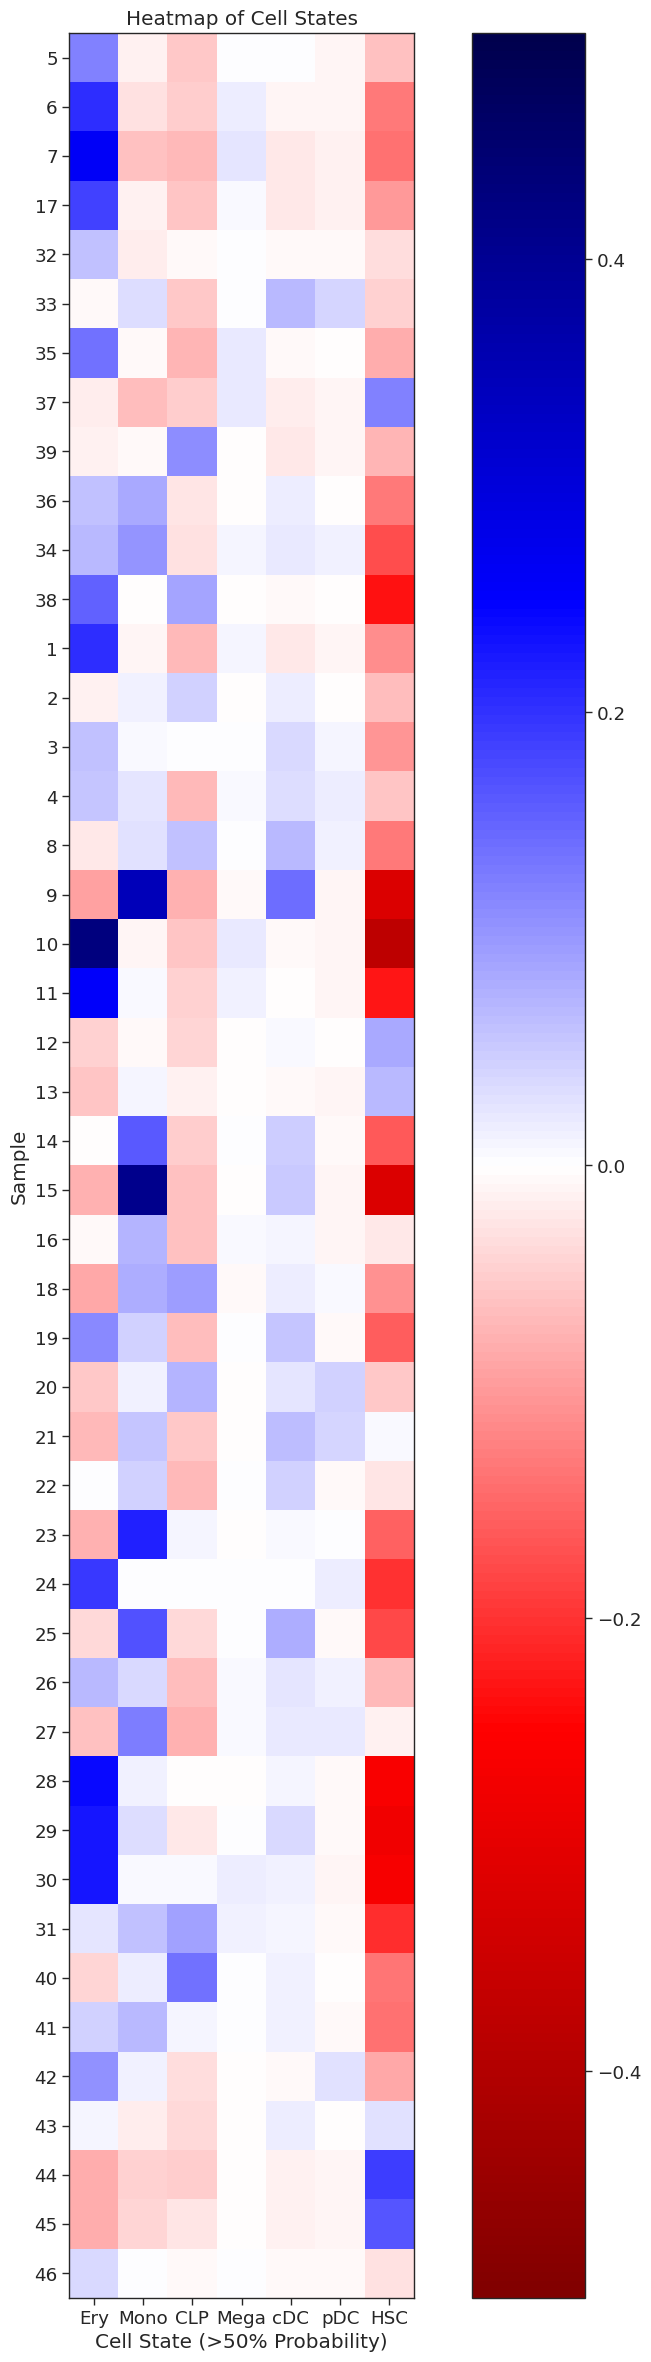

In [11]:
#Plot regular heatmap with all samples
#Set figure size and resolution
plt.rcParams['figure.figsize'] = [15, 30]
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State (>50% Probability)")
plt.ylabel("Sample")
plt.title("Heatmap of Cell States")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = map(str, ordering)
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/heatMapAllSamplesRelative_threshold=0.5.pdf')

In [13]:
#Plot a heatmap of the selected pseudo-bulk sequencing group (here we plot group 4)
#orderingGroup1 = [9, 14, 15, 18, 23, 25, 27, 31, 34]
#orderingGroup2 = [40,41,42,43,44,45,46]
#orderingGroup3 = [1, 5, 10, 19, 24, 28, 29, 30, 36, 38]
orderingGroup4 = [6, 12, 7, 17, 37, 13, 32, 39, 35, 16, 22, 20, 2, 8, 21, 3, 26, 4, 33]
percentagesNumPy_HSC2 = np.zeros((len(orderingGroup4),8))
cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingGroup4:
    percentagesNumPy_HSC2[count,:] = csv_import_fn(i, cols)
    count = count+1

In [14]:
#Subtract average of normals to plot the relative percentages
normalsOnly = percentagesNumPy_HSC[39:,:]
averages = np.mean(normalsOnly,0)

plotRelative2 = percentagesNumPy_HSC2-averages

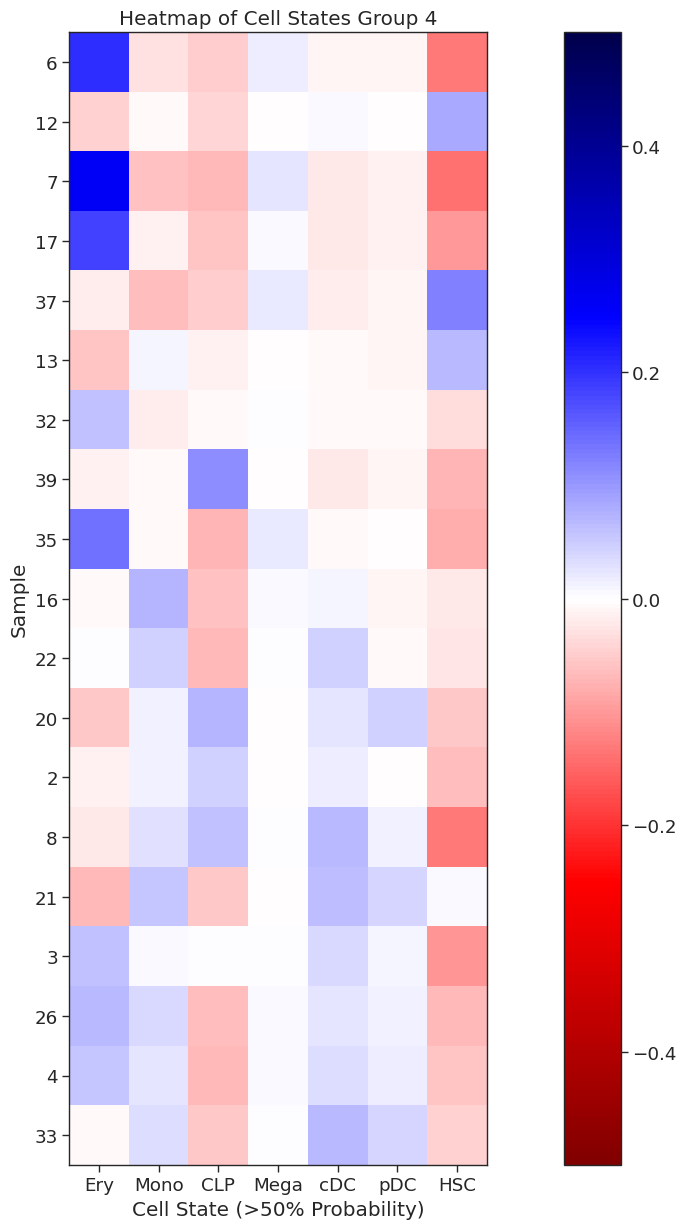

In [19]:
#Set figure size and resolution
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative2.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative2[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State (>50% Probability)")
plt.ylabel("Sample")
plt.title("Heatmap of Cell States Group 4")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = map(str, orderingGroup4)
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/heatMapRelativeGroup4.pdf')

In [20]:
#Plot heatmap of averages between bulk groups relative to the normals
orderingGroup1 = [9, 14, 15, 18, 23, 25, 27, 31, 34]
orderingGroup2 = [40, 41, 42, 43, 44, 45, 46]
orderingGroup3 = [1, 5, 10, 11, 19, 24, 28, 29, 30, 36, 38]
orderingGroup4 = [6, 12, 7, 17, 37, 13, 32, 39, 35, 16, 22, 20, 2, 8, 21, 3, 26, 4, 33]
percentagesNumPy_HSCGroup1 = np.zeros((len(orderingGroup1),8))
percentagesNumPy_HSCGroup2 = np.zeros((len(orderingGroup2),8))
percentagesNumPy_HSCGroup3 = np.zeros((len(orderingGroup3),8))
percentagesNumPy_HSCGroup4 = np.zeros((len(orderingGroup4),8))
cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingGroup1:
    percentagesNumPy_HSCGroup1[count,:] = csv_import_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup2:
    percentagesNumPy_HSCGroup2[count,:] = csv_import_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup3:
    percentagesNumPy_HSCGroup3[count,:] = csv_import_fn(i, cols)
    count = count+1
count = 0
for i in orderingGroup4:
    percentagesNumPy_HSCGroup4[count,:] = csv_import_fn(i, cols)
    count = count+1

In [21]:
#Subtract average of normals to plot the relative percentages
normalsOnly = percentagesNumPy_HSC[39:,:]
averages = np.mean(normalsOnly,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCGroup1-averages
plotRelativeGroup2 = percentagesNumPy_HSCGroup2-averages
plotRelativeGroup3 = percentagesNumPy_HSCGroup3-averages
plotRelativeGroup4 = percentagesNumPy_HSCGroup4-averages

#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)
plotRelativeByAvg4 = np.mean(plotRelativeGroup4, axis =0)

#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2, plotRelativeByAvg3, plotRelativeByAvg4))
plotRelative3

array([[-2.18880729e-03, -3.66130361e-02,  1.85479025e-01,
        -1.42382130e-02,  2.22441571e-03,  4.44278750e-02,
         1.04389773e-03, -1.81280067e-01],
       [-3.17206578e-17,  3.96508223e-18,  1.48690584e-17,
         1.18952467e-17, -6.81498508e-19, -3.71726459e-18,
         0.00000000e+00,  0.00000000e+00],
       [-1.31939268e-01,  2.02337089e-01,  1.40050429e-02,
        -2.25593403e-02,  6.12840073e-03,  9.37168153e-03,
        -5.23108938e-03, -2.09282874e-01],
       [-1.18093718e-02,  3.90125945e-02,  7.28362883e-03,
        -2.29709146e-02,  5.29428446e-03,  1.53460819e-02,
         4.63957925e-03, -4.39656751e-02]])

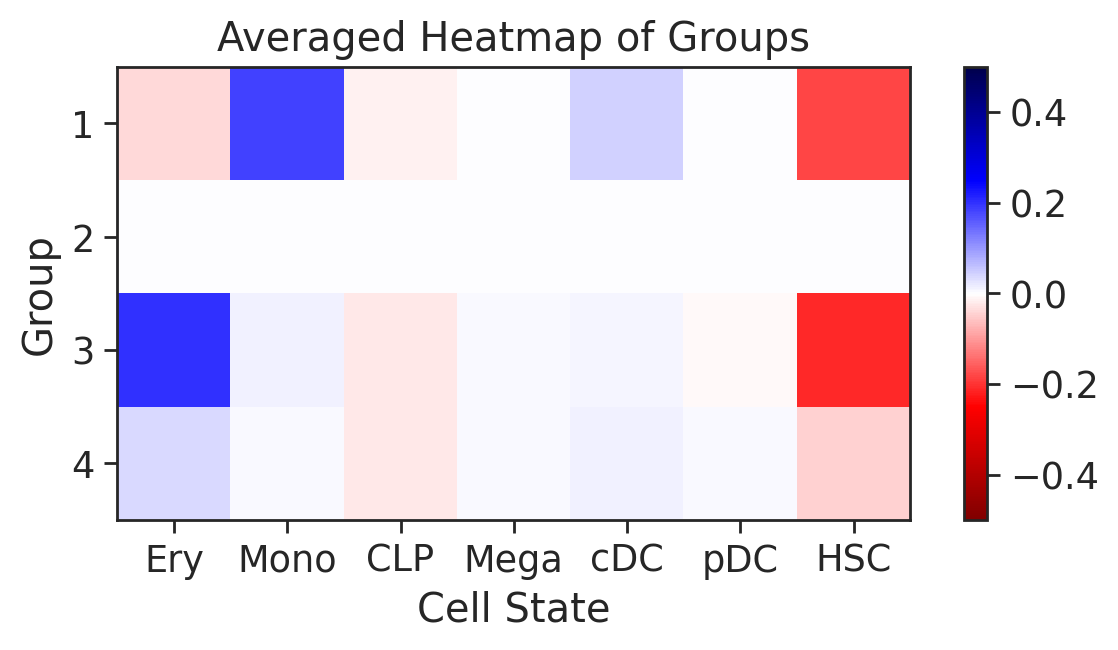

In [22]:
#Plot the averaged expression of the groups

#Set order
orderingGroup = [1,2,3,4]

#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Averaged Heatmap of Groups")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = map(str, orderingGroup)
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/mainPaper/heatMapRelativeSortedByBulkGroup_withNormal.pdf')

In [27]:
#Plot heatmap of averages between HMA and normal relative to the normals
orderingHMA = [5,6,7,17,32,33,35,37,39]
orderingNormal = [40, 41, 42, 43, 44, 45, 46]
orderingCMML = [1,2,3,4,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

percentagesNumPy_HSCHMA = np.zeros((len(orderingHMA),8))
percentagesNumPy_HSCNormal = np.zeros((len(orderingNormal),8))
percentagesNumPy_HSCCMML = np.zeros((len(orderingCMML),8))

cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingHMA:
    percentagesNumPy_HSCHMA[count,:] = csv_import_fn(i, cols)
    count = count+1
count=0
for i in orderingNormal:
    percentagesNumPy_HSCNormal[count,:] = csv_import_fn(i, cols)
    count = count+1
count=0
for i in orderingCMML:
    percentagesNumPy_HSCCMML[count,:] = csv_import_fn(i, cols)
    count = count+1
count = 0


In [28]:
#Subtract average of normals to plot the relative percentages
normalsOnly = percentagesNumPy_HSC[39:,:]
averages = np.mean(normalsOnly,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCHMA-averages
plotRelativeGroup2 = percentagesNumPy_HSCNormal-averages
plotRelativeGroup3 = percentagesNumPy_HSCCMML-averages

#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)

#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2, plotRelativeByAvg3))
plotRelative3

array([[-2.22514517e-02,  1.04342437e-01, -1.96644057e-02,
        -3.28748303e-02,  1.05501687e-02, -3.38254353e-03,
        -3.22209620e-03, -5.89708265e-02],
       [-3.17206578e-17,  3.96508223e-18,  1.48690584e-17,
         1.18952467e-17, -6.81498508e-19, -3.71726459e-18,
         0.00000000e+00,  0.00000000e+00],
       [-4.22465036e-02,  5.24617561e-02,  7.24623074e-02,
        -2.03553510e-02,  3.12011773e-03,  2.93524192e-02,
         2.25166627e-03, -1.37041249e-01]])

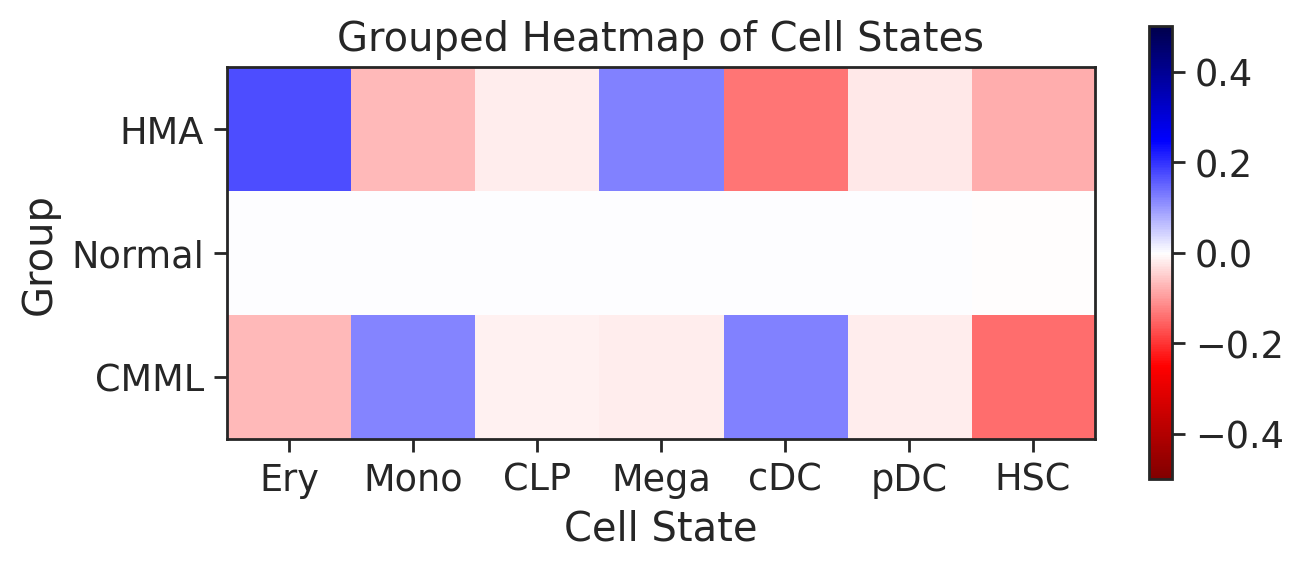

In [37]:
#Plot the heatmap of average expression in cmml vs hma with normals as reference

#Set order
orderingGroup = [1,2,3]

#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Grouped Heatmap of Cell States")

#label samples appropiately to match Group
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = ["HMA", "Normal", "CMML"]
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/supplemental/heatMapRelativeSortedByCondition_withNormal.pdf')

In [32]:
## define function to read in branchProbs, subset to only include cells 
## between 1 and 1.25 in diferentiation potential,
##   and fassign cell state to percent greater than X (.3)
def csv_import_bump_fn(i, colNames):
    if (i<40):
        sampleID = 'cmml'+str(i)
    else:
        sampleID = 'normal'+str(i-39)
    
    #Import dataframe from r specifying diff potential and branch Prob
    branchProb_diffPot_df = pd.read_csv(filedir+sampleID+'branchProbs_diffPot.csv', index_col=0)

    branchProb_diffPot_df = branchProb_diffPot_df[cols]
    
    #Subset the dataframe to only cells in bump (1-1.25 diffPot)
    branchProb_diffPot_df = branchProb_diffPot_df[(branchProb_diffPot_df.DiffPot>1) & (branchProb_diffPot_df.DiffPot<1.25)]
    
    #Count how many cells we have
    denominator = branchProb_diffPot_df.count()[1]

    #Count the cells with >50% branch probability for each branch
    gt75 = branchProb_diffPot_df.gt(.3)
    outputArray = gt75.sum()

    #Convert to numpy array and add the unassigned cells to 5th column (HSC Precursors)
    percent = outputArray/denominator
    percentages = np.zeros(8)
    percentages = percent.values

    percentages = np.append(percentages, 1-sum(percentages[1:6]))
    return percentages

In [33]:
#Plot heatmap of averages between HMA and No Tx relative to the normals
orderingHMA = [5,6,7,17,32,33,35,37,39]
orderingNormal = [40, 41, 42, 43, 44, 45, 46]
orderingCMML = [1,2,3,4,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

percentagesNumPy_HSCHMA = np.zeros((len(orderingHMA),8))
percentagesNumPy_HSCNormal = np.zeros((len(orderingNormal),8))
percentagesNumPy_HSCCMML = np.zeros((len(orderingCMML),8))

cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingHMA:
    percentagesNumPy_HSCHMA[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingNormal:
    percentagesNumPy_HSCNormal[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingCMML:
    percentagesNumPy_HSCCMML[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count = 0


In [34]:
#Subtract average of normals to plot the relative percentages
averages = np.mean(percentagesNumPy_HSCNormal,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCHMA-averages
plotRelativeGroup2 = percentagesNumPy_HSCNormal-averages
plotRelativeGroup3 = percentagesNumPy_HSCCMML-averages

#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)

#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2, plotRelativeByAvg3))
plotRelative3

array([[ 0.00000000e+00,  1.74913873e-01, -6.94374404e-02,
        -1.56308843e-02,  1.23474897e-01, -1.33194353e-01,
        -2.07529160e-02, -8.01260918e-02],
       [ 0.00000000e+00, -1.38777878e-17, -2.37904934e-17,
        -1.23908820e-18, -4.95635279e-18,  8.72318091e-17,
        -9.91270558e-18, -8.72318091e-17],
       [ 0.00000000e+00, -6.99144491e-02,  1.19669383e-01,
        -1.25656861e-02, -1.57770700e-02,  1.22411691e-01,
        -1.86285462e-02, -1.43823869e-01]])

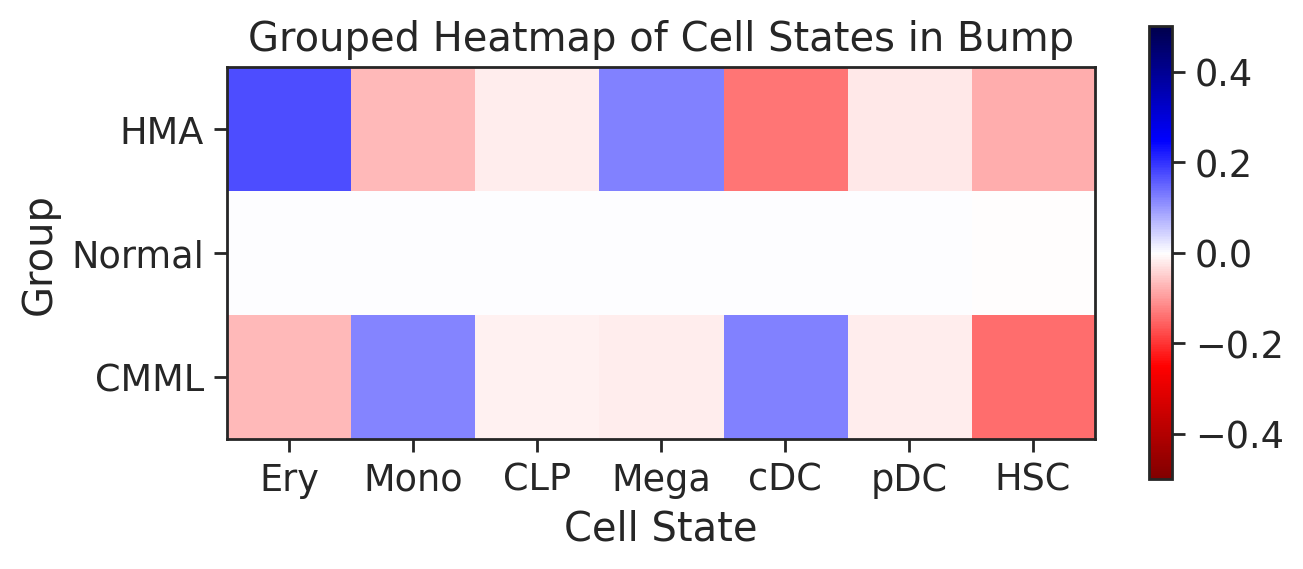

In [36]:
orderingGroup = [1,2,3]
#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Grouped Heatmap of Cell States in Bump")

#label samples appropiately to match Group
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = ["HMA", "Normal", "CMML"]
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/supplemental/heatMapRelative_inBump_SortedByCondition_withNormal.pdf')

In [38]:
#Plot heatmap of averages between bulk groups relative to the normals in BUMP
orderingGroup1 = [9, 14, 15, 18, 23, 25, 27, 31, 34]
orderingGroup2 = [40, 41, 42, 43, 44, 45, 46]
orderingGroup3 = [1, 5, 10, 11, 19, 24, 28, 29, 30, 36, 38]
orderingGroup4 = [6, 12, 7, 17, 37, 13, 32, 39, 35, 16, 22, 20, 2, 8, 21, 3, 26, 4, 33]
percentagesNumPy_HSCGroup1 = np.zeros((len(orderingGroup1),8))
percentagesNumPy_HSCGroup2 = np.zeros((len(orderingGroup2),8))
percentagesNumPy_HSCGroup3 = np.zeros((len(orderingGroup3),8))
percentagesNumPy_HSCGroup4 = np.zeros((len(orderingGroup4),8))
cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingGroup1:
    percentagesNumPy_HSCGroup1[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup2:
    percentagesNumPy_HSCGroup2[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup3:
    percentagesNumPy_HSCGroup3[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count = 0
for i in orderingGroup4:
    percentagesNumPy_HSCGroup4[count,:] = csv_import_bump_fn(i, cols)
    count = count+1

In [39]:
#Subtract average of normals to plot the relative percentages
averages = np.mean(percentagesNumPy_HSCGroup2,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCGroup1-averages
plotRelativeGroup2 = percentagesNumPy_HSCGroup2-averages
plotRelativeGroup3 = percentagesNumPy_HSCGroup3-averages
plotRelativeGroup4 = percentagesNumPy_HSCGroup4-averages

#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)
plotRelativeByAvg4 = np.mean(plotRelativeGroup4, axis =0)

#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2, plotRelativeByAvg3, plotRelativeByAvg4))
plotRelative3

array([[ 0.00000000e+00, -1.34632426e-01,  2.62276556e-01,
        -1.10927722e-02, -4.67625640e-02,  2.14166255e-01,
        -6.52059466e-02, -2.83955049e-01],
       [ 0.00000000e+00, -1.38777878e-17, -2.37904934e-17,
        -1.23908820e-18, -4.95635279e-18,  8.72318091e-17,
        -9.91270558e-18, -8.72318091e-17],
       [ 0.00000000e+00,  1.14551267e-02,  7.14831046e-02,
        -1.16018279e-02,  2.13942913e-02,  1.13636795e-02,
        -3.52345779e-02, -1.04094374e-01],
       [ 0.00000000e+00,  2.57928023e-02, -4.71432855e-03,
        -1.46971719e-02,  4.17855666e-02,  2.33622703e-02,
         1.00355566e-02, -7.15291387e-02]])

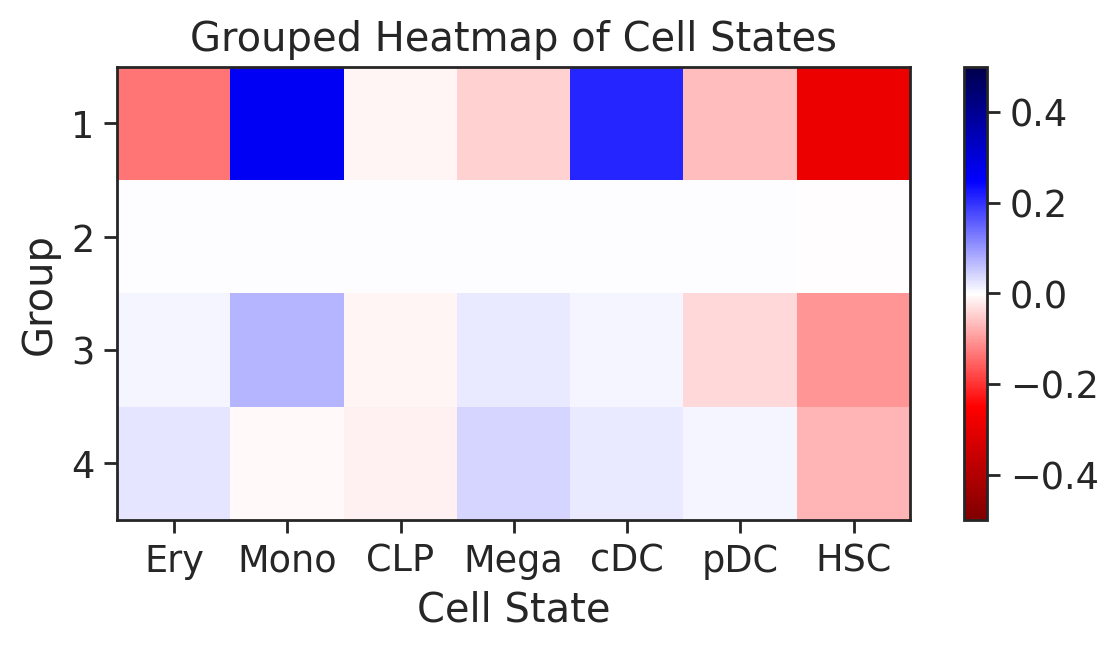

In [40]:
#Make heatmap showing bulk groups in bump

#set order
orderingGroup = [1,2,3,4]

#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Grouped Heatmap of Cell States")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = map(str, orderingGroup)
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/mainPaper/heatMapRelative_InBump_SortedByBulkGroup_withNormal_.4.pdf')

In [44]:
#Plot heatmap of averages between those with big bump and those without
orderingGroup1 = [9, 10, 11, 14, 15, 29, 30] #Big Bump
orderingGroup2 = [40, 41, 42, 43, 44, 45, 46] #Normals
orderingGroup3 = [1, 2,3,4,8,9,12,13,16,18,19,20,21,22,23,24,25,26,27,28,31] #Normal Bump

percentagesNumPy_HSCGroup1 = np.zeros((len(orderingGroup1),8))
percentagesNumPy_HSCGroup2 = np.zeros((len(orderingGroup2),8))
percentagesNumPy_HSCGroup3 = np.zeros((len(orderingGroup3),8))

cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in orderingGroup1:
    percentagesNumPy_HSCGroup1[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup2:
    percentagesNumPy_HSCGroup2[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in orderingGroup3:
    percentagesNumPy_HSCGroup3[count,:] = csv_import_bump_fn(i, cols)
    count = count+1



In [45]:
#Subtract average of normals to plot the relative percentages
averages = np.mean(percentagesNumPy_HSCGroup2,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCGroup1-averages
plotRelativeGroup2 = percentagesNumPy_HSCGroup2-averages
plotRelativeGroup3 = percentagesNumPy_HSCGroup3-averages


#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)


#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2, plotRelativeByAvg3))
plotRelative3

array([[ 0.00000000e+00, -3.73715386e-02,  1.81422905e-01,
        -1.22114237e-02, -4.86949423e-04,  9.43109962e-02,
        -7.89207709e-02, -2.25663989e-01],
       [ 0.00000000e+00, -1.38777878e-17, -2.37904934e-17,
        -1.23908820e-18, -4.95635279e-18,  8.72318091e-17,
        -9.91270558e-18, -8.72318091e-17],
       [ 0.00000000e+00, -8.50036617e-02,  1.10114250e-01,
        -1.28378515e-02, -2.30560590e-02,  1.40087585e-01,
        -2.66365132e-03, -1.29304263e-01]])

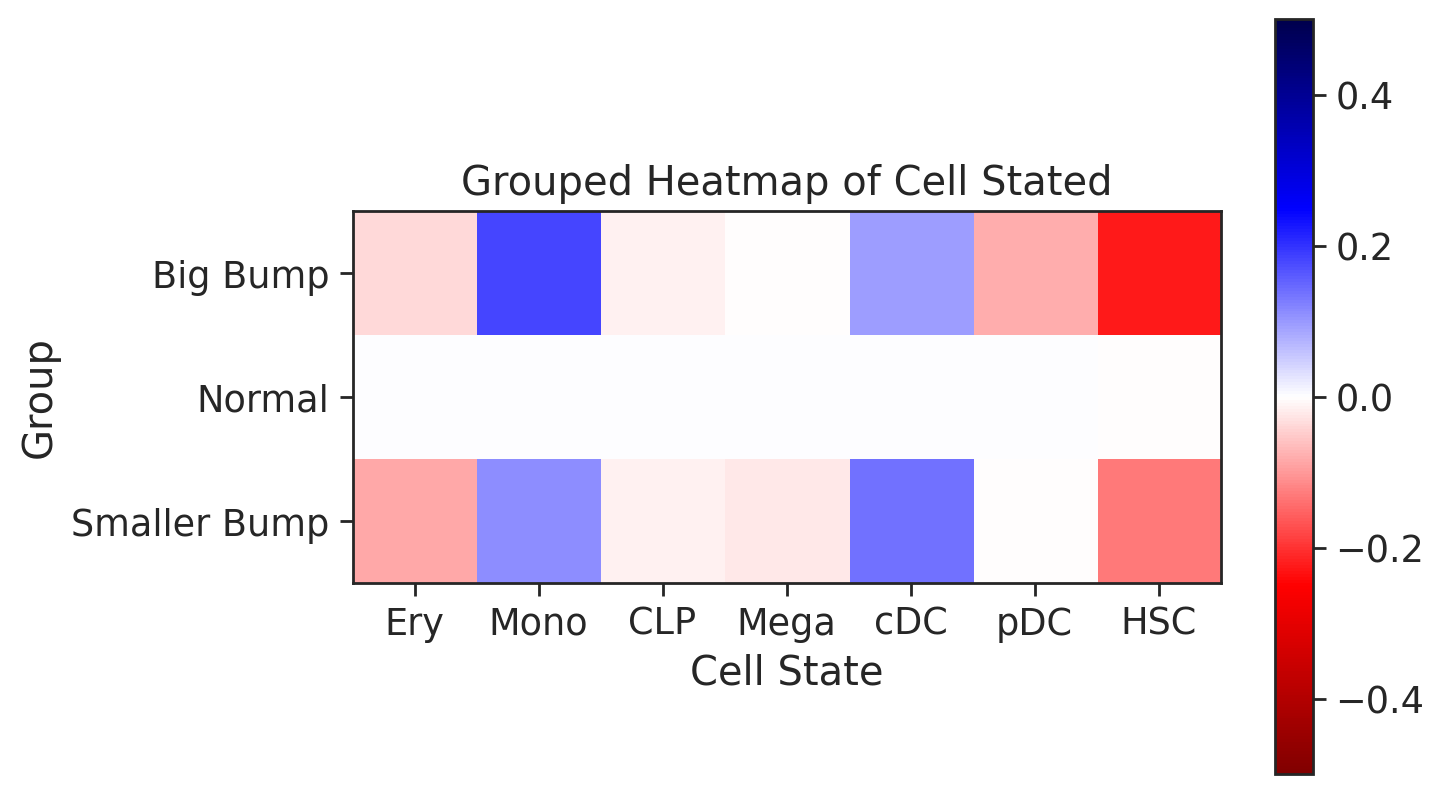

In [46]:
#Make heatmap of those with a big bump (>1SD from mean) and those with normal bump and normals

#Set order
orderingGroup = [1,2,3]

#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Grouped Heatmap of Cell Stated")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = ["Big Bump", "Normal", "Smaller Bump"]
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/mainPaper/heatMapRelative_SortedbyBump_inBump_withNormal_.3.pdf')

In [47]:
##  Define function to import only cells outside of the bump (<1 or > 1.25)
## and assign cell state for percent greater than X (.3)
def csv_import_outsideBump_fn(i, colNames):
    if (i<40):
        sampleID = 'cmml'+str(i)
    else:
        sampleID = 'normal'+str(i-39)
    
    #Import dataframe from r specifying diff potential and branch Prob
    branchProb_diffPot_df = pd.read_csv(filedir+sampleID+'branchProbs_diffPot.csv', index_col=0)

    branchProb_diffPot_df = branchProb_diffPot_df[cols]
    
    #Subset the dataframe to only cells in bump (1-1.25 diffPot)
    branchProb_diffPot_df = branchProb_diffPot_df[(branchProb_diffPot_df.DiffPot>1.25)|(branchProb_diffPot_df.DiffPot<1.0)]
    
    #Count how many cells we have
    denominator = branchProb_diffPot_df.count()[1]

    #Count the cells with >50% branch probability for each branch
    gt75 = branchProb_diffPot_df.gt(.3)
    outputArray = gt75.sum()

    #Convert to numpy array and add the unassigned cells to 5th column (HSC Precursors)
    percent = outputArray/denominator
    percentages = np.zeros(8)
    percentages = percent.values

    percentages = np.append(percentages, 1-sum(percentages[1:6]))
    return percentages

In [48]:
#Plot heatmap of averages between bulk groups relative to the normals in Second BUMP
#orderingGroup1 = [9, 14, 15, 18, 23, 25, 27, 31, 34]
#orderingGroup2 = [40, 41, 42, 43, 44, 45, 46]
#orderingGroup3 = [1, 5, 10, 11, 19, 24, 28, 29, 30, 36, 38]
#orderingGroup4 = [6, 12, 7, 17, 37, 13, 32, 39, 35, 16, 22, 20, 2, 8, 21, 3, 26, 4, 33]
cmmlGroup = [1,2,3,4,8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
percentagesNumPy_HSCGroup1 = np.zeros((len(cmmlGroup),8))
percentagesNumPy_HSCGroup2 = np.zeros((len(cmmlGroup),8))
#percentagesNumPy_HSCGroup3 = np.zeros((len(orderingGroup3),8))
#percentagesNumPy_HSCGroup4 = np.zeros((len(orderingGroup4),8))
cols2 = ["DiffPot","Ery", "Mono", "CLP", "Mega", "cDC", "pDC"]

count=0
for i in cmmlGroup:
    percentagesNumPy_HSCGroup1[count,:] = csv_import_bump_fn(i, cols)
    count = count+1
count=0
for i in cmmlGroup:
    percentagesNumPy_HSCGroup2[count,:] = csv_import_outsideBump_fn(i, cols)
    count = count+1
#count=0
#for i in orderingGroup3:
#    percentagesNumPy_HSCGroup3[count,:] = csv_import_bump2_fn(i, cols)
#    count = count+1
#count = 0
#for i in orderingGroup4:
##    percentagesNumPy_HSCGroup4[count,:] = csv_import_bump2_fn(i, cols)
#    count = count+1

In [49]:
#Subtract average of normals to plot the relative percentages
averages = np.mean(percentagesNumPy_HSCGroup2,0)

#subtract normals from each one
plotRelativeGroup1 = percentagesNumPy_HSCGroup1-averages
plotRelativeGroup2 = percentagesNumPy_HSCGroup2-averages
#plotRelativeGroup3 = percentagesNumPy_HSCGroup3-averages
#plotRelativeGroup4 = percentagesNumPy_HSCGroup4-averages

#get average of each one (across samples)
plotRelativeByAvg1 = np.mean(plotRelativeGroup1, axis =0)
plotRelativeByAvg2 = np.mean(plotRelativeGroup2, axis =0)
#plotRelativeByAvg3 = np.mean(plotRelativeGroup3, axis =0)
#plotRelativeByAvg4 = np.mean(plotRelativeGroup4, axis =0)

#Combine them into one array
plotRelative3 = np.vstack((plotRelativeByAvg1, plotRelativeByAvg2))#, plotRelativeByAvg3, plotRelativeByAvg4))
plotRelative3

array([[ 1.74947271e-01, -1.38913872e-01,  3.15460839e-01,
        -6.93893459e-02,  2.20693849e-02,  3.84511445e-01,
         6.83226170e-02, -5.13738450e-01],
       [ 1.64477485e-17,  4.11193713e-18, -6.16790569e-17,
         2.05596856e-17,  6.16790569e-18,  1.43917799e-17,
        -2.50571169e-18,  5.13992141e-19]])

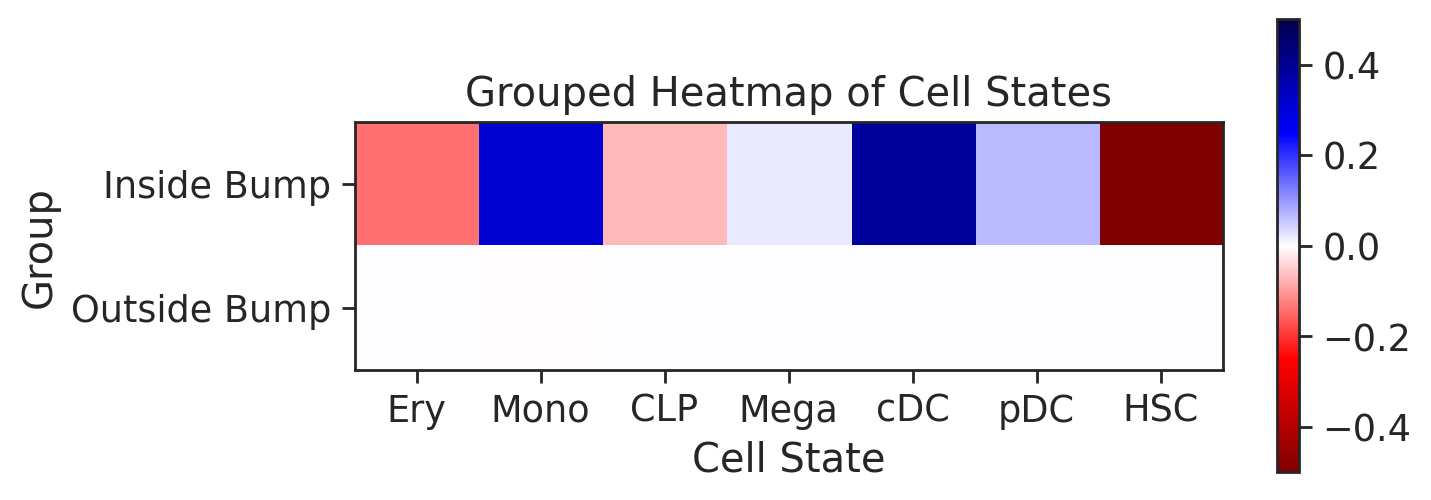

In [50]:
#Make heatmap using all cmml cells outside bump as reference and 
## conpare the cells inside bump to see bias

orderingGroup = [1,2]
#Set figure size and resolution
plt.rcParams['figure.figsize'] = [7, 3]
plt.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(1,1)
num_rows, num_cols = plotRelative3.shape

#Exclude first row (diff potential) to show only branch probablities (not diff potential)
img = ax.imshow(plotRelative3[:,1:],extent=[0,num_cols-1,0,num_rows], cmap = 'seismic_r', clim=[-.5,.5])

#add axis labels and title
plt.xlabel("Cell State")
plt.ylabel("Group")
plt.title("Grouped Heatmap of Cell States")

#label samples appropiately to match sample number and cell state
col_labels = np.append(cols, "HSC")
x_label_list = col_labels[1:]
y_label_str = ["Inside Bump", "Outside Bump"]
y_label_list = y_label_str

#Set label ticks
ax.set_xticks(np.linspace(0,(num_cols-2),num_cols-1)+.5)
ax.set_yticks(np.linspace((num_rows-1),0,num_rows)+.5)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

fig.colorbar(img)

#Save figure
plt.savefig('/Users/4472241/scCode/Paper_Figures/mainPaper/heatMapRelativeBump1_InBumpvsOutBump_SortedByBulkGroup_withNormal_.4.pdf')